In [4]:
import sys
sys.path.append('../rdtools')
from system_analysis import SystemAnalysis
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

idx = pd.date_range('2019-01-01 10:00', freq='h', periods=100)
df = pd.DataFrame(index=idx, data={
    'pv': 900,
    'poa': 1000,
    'tamb': 18,
    'windspeed': 1,
})
kWdc = 1000
gamma_pdc = -0.0043

sa = SystemAnalysis(
    pv=df['pv'],
    poa=df['poa'],
    ambient_temperature=df['tamb'],
    windspeed=df['windspeed'],
    kWdc=kWdc,
    gamma_pdc=gamma_pdc,
    system_size=kWdc,
    dc_model='pvwatts',
    g_ref=1000,
    t_ref=25
)

DEBUG: registering plugin calc_cell_temperature: ['poa', 'windspeed', 'ambient_temperature']->['cell_temperature']
DEBUG: registering plugin pvwatts: ['poa', 'cell_temperature', 'gamma_pdc', 'system_size', 'g_ref', 't_ref']->['pvwatts_expected_power']
DEBUG: registering plugin sapm: ['pvlib_localized_pvsystem', 'dni', 'ghi', 'dhi', 'ambient_temperature', 'windspeed']->['sapm_expected_power']
DEBUG: registering plugin expected_power: ['dc_model']->['expected_power']
DEBUG: registering plugin normalize: ['pv', 'expected_power']->['normalized']
DEBUG: registering plugin get_times: ['pv']->['times']
DEBUG: registering plugin get_solarposition: ['pvlib_location', 'times']->['solar_position']
DEBUG: registering plugin get_clearsky_irradiance: ['pvlib_location', 'times']->['clearsky_irradiance']
DEBUG: registering plugin get_clearsky_poa: ['pv_tilt', 'pv_azimuth', 'albedo', 'solar_position', 'clearsky_irradiance']->['clearsky_poa_raw']
DEBUG: registering plugin rescale_poa: ['clearsky_poa_raw

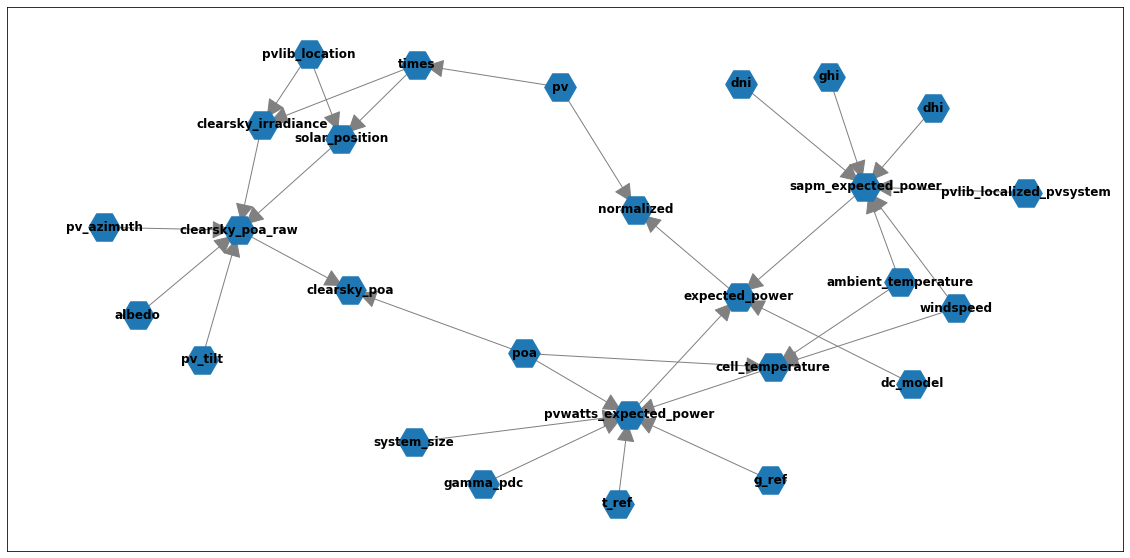

In [5]:
sa.diagram()

In [6]:
sa.calculate('normalized')

DEBUG: checking prerequisites for normalize: ['pv', 'expected_power']
DEBUG: requirement already satisfied: pv
DEBUG: calculating requirement expected_power with provider expected_power
DEBUG: checking prerequisites for expected_power: ['dc_model']
DEBUG: requirement already satisfied: dc_model
DEBUG: calculating requirement pvwatts_expected_power with provider pvwatts
DEBUG: calculating requirement sapm_expected_power with provider sapm
DEBUG: calling expected_power with requires=['dc_model'], optional=['pvwatts_expected_power', 'sapm_expected_power'], and kwargs=[]
DEBUG: checking prerequisites for pvwatts: ['poa', 'cell_temperature', 'gamma_pdc', 'system_size', 'g_ref', 't_ref']
DEBUG: requirement already satisfied: poa
DEBUG: calculating requirement cell_temperature with provider calc_cell_temperature
DEBUG: checking prerequisites for calc_cell_temperature: ['poa', 'windspeed', 'ambient_temperature']
DEBUG: requirement already satisfied: poa
DEBUG: requirement already satisfied: wi

2019-01-01 10:00:00    1.009973
2019-01-01 11:00:00    1.009973
2019-01-01 12:00:00    1.009973
2019-01-01 13:00:00    1.009973
2019-01-01 14:00:00    1.009973
2019-01-01 15:00:00    1.009973
2019-01-01 16:00:00    1.009973
2019-01-01 17:00:00    1.009973
2019-01-01 18:00:00    1.009973
2019-01-01 19:00:00    1.009973
2019-01-01 20:00:00    1.009973
2019-01-01 21:00:00    1.009973
2019-01-01 22:00:00    1.009973
2019-01-01 23:00:00    1.009973
2019-01-02 00:00:00    1.009973
2019-01-02 01:00:00    1.009973
2019-01-02 02:00:00    1.009973
2019-01-02 03:00:00    1.009973
2019-01-02 04:00:00    1.009973
2019-01-02 05:00:00    1.009973
2019-01-02 06:00:00    1.009973
2019-01-02 07:00:00    1.009973
2019-01-02 08:00:00    1.009973
2019-01-02 09:00:00    1.009973
2019-01-02 10:00:00    1.009973
2019-01-02 11:00:00    1.009973
2019-01-02 12:00:00    1.009973
2019-01-02 13:00:00    1.009973
2019-01-02 14:00:00    1.009973
2019-01-02 15:00:00    1.009973
                         ...   
2019-01-